## **Посмотрим сначала на собранные данные**

In [2]:
!wget --no-check-certificate https://raw.githubusercontent.com/Myashka/IVICT.HACK-team-HI/data/dataset.csv

--2022-05-21 14:25:20--  https://raw.githubusercontent.com/Myashka/IVICT.HACK-team-HI/data/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 8106782 (7.7M) [text/plain]
Saving to: 'dataset.csv'

     0K .......... .......... .......... .......... ..........  0%  476K 17s
    50K .......... .......... .......... .......... ..........  1%  586K 15s
   100K .......... .......... .......... .......... ..........  1% 5.85M 10s
   150K .......... .......... .......... .......... ..........  2% 1.03M 10s
   200K .......... .......... .......... .......... ..........  3%  677K 10s
   250K .......... .......... .......... .......... ..........  3% 10.1M 8s
   300K .......... .......... .......... ..........

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import numpy as np

from tqdm.auto import tqdm
import os
import time

In [4]:
dataset = pd.read_csv('dataset.csv', usecols=[1,2])
dataset.head(5)

,text,label
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral


In [5]:
dataset.label.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger',
       'joy'], dtype=object)

In [ ]:
len(dataset.label.unique())

14

In [19]:
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81459 entries, 0 to 81458
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    81459 non-null  object
 1   label   81459 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
texts = dataset['text'].tolist()
labels = dataset['label'].values

### Начнем сразу с Bert'а:


1.   Прогоним через него наши данные и выведем t-SNE, чтобы хоть как-то их представить
2.   Обучим из коробки различные классификаторы sklearn, оценивая f1 и roc-auc
3.   Оптимизируем кногоклассовую классиифкацию на pyTorch, используя CrossEntropy
4.   Обучаем Bert и тестируем далее...

In [7]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: certifi>=2017.4.17 in c:\programdata\anaconda3\lib\site-packages (from requests->transformers) (2021.10.8)



You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [8]:
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer, logging

In [9]:
logging.set_verbosity_error()  # Ignore warning on model loading.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Токенезируем наши текстовые данные, посмотрим на то, что возвращает модель

In [10]:
tokenized_texts = tokenizer(dataset['text'].tolist(), return_tensors="pt", padding=True, truncation=True)

for key, values in tokenized_texts.items():
    values_type = type(values).__name__
    print(f"{key}: {values_type}, {values.shape}")

input_ids: Tensor, torch.Size([81459, 110])
attention_mask: Tensor, torch.Size([81459, 110])


Получилось максимально 110 токенов, посмотрим на attention_mask - в конце много нулей, из-за padding

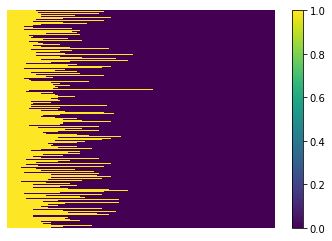

In [ ]:
plt.pcolormesh(tokenized_texts["attention_mask"])
plt.axis("off")
plt.colorbar()
plt.show()

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [12]:
device

device(type='cuda', index=0)

In [13]:
batch_size = 32
features = []
with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        texts_batch = tokenized_texts["input_ids"][i : i + batch_size].to(device)
        masks_batch = tokenized_texts["attention_mask"][i : i + batch_size].to(device)
        output = model(texts_batch, masks_batch)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(batch_features)

features = np.concatenate(features, axis=0)
features.shape

  0%|          | 0/2546 [00:00<?, ?it/s]

(81459, 768)

### Поиск pipeline'а 

In [72]:
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve, classification_report

In [37]:
from scikitplot.metrics import plot_roc

In [79]:
def evaluation(pipeline, X_test, y_test):
    y_predict = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)
    
    print(classification_report(y_test, y_predict))
    
    plot_roc(y_test, y_proba, figsize=(10,8))
    plt.show()
    return{
        'f1': f1_score(y_test, y_predict, average='micro'),
        'roc_auc_score_macro': roc_auc_score(y_test, y_proba, average='macro', multi_class='ovr'),
    }

In [80]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, shuffle=True)

##### LogisticRegression

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
lr_clf = LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='saga').fit(train_features, train_labels)

KeyboardInterrupt: 

              precision    recall  f1-score   support

       anger       0.47      0.68      0.55      1706
     boredom       0.05      0.53      0.09        53
       empty       0.06      0.38      0.10       242
  enthusiasm       0.07      0.49      0.13       229
         fun       0.13      0.41      0.20       509
   happiness       0.40      0.08      0.13      3660
        hate       0.15      0.54      0.24       418
         joy       0.39      0.69      0.49      2056
        love       0.41      0.43      0.42      2159
     neutral       0.44      0.28      0.34      2571
      relief       0.22      0.17      0.19       471
     sadness       0.69      0.44      0.54      5194
    surprise       0.29      0.37      0.32      1114
       worry       0.56      0.24      0.34      4056

    accuracy                           0.37     24438
   macro avg       0.31      0.41      0.29     24438
weighted avg       0.47      0.37      0.37     24438



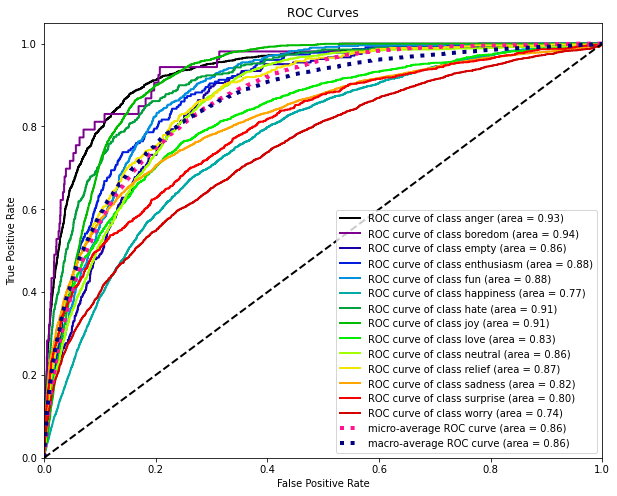

{'f1': 0.36574187740404285, 'roc_auc_score_macro': 0.857703359326579}

In [83]:
evaluation(lr_clf, test_features, test_labels)

###### Test case

In [119]:
text = '''Yesterday, all my troubles seemed so far away
Now it looks as though they’re here to stay
Oh, I believe in yesterday.
Suddenly, I’m not half the man I used to be,
There’s a shadow hanging over me.
Oh, yesterday came suddenly.
Why she had to go I don’t know she woldn’t say.
I said something wrong, now I long for yesterday.
Yesterday, love was such an easy game to play.
Now I need a place to hide away.
Oh, I believe in yesterday.'''

In [235]:
def predic_from_text(text, classifier):
    with torch.no_grad():
        tokenized_text = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad():
            output = model(**tokenized_text)
        features = output.last_hidden_state[:, 0, :].cpu().numpy()
    
    
    answer = classifier.predict_proba(features)
    
    emotions = np.argsort(answer)[0][::-1][:6]
    
    return classifier.classes_[emotions], answer

In [236]:
emotions, prediction_probas = predic_from_text('''Yesterday, all my troubles seemed so far away
Now it looks as though they’re here to stay
Oh, I believe in yesterday.
Suddenly, I’m not half the man I used to be,
There’s a shadow hanging over me.
Oh, yesterday came suddenly.
Why she had to go I don’t know she woldn’t say.
I said something wrong, now I long for yesterday.
Yesterday, love was such an easy game to play.
Now I need a place to hide away.
Oh, I believe in yesterday.''', lr_clf)

In [237]:
emotions

array(['love', 'happiness', 'worry', 'sadness', 'surprise', 'relief'],
      dtype=object)

###### End of test case

### RandomForest

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
rf_clf = RandomForestClassifier().fit(train_features, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.96      0.69      0.80      1706
     boredom       0.00      0.00      0.00        53
       empty       0.00      0.00      0.00       242
  enthusiasm       0.00      0.00      0.00       229
         fun       0.50      0.00      0.00       509
   happiness       0.20      0.22      0.21      3660
        hate       0.00      0.00      0.00       418
         joy       0.06      0.05      0.06      2056
        love       0.72      0.43      0.54      2159
     neutral       0.34      0.55      0.42      2571
      relief       0.00      0.00      0.00       471
     sadness       0.59      0.73      0.66      5194
    surprise       0.98      0.26      0.41      1114
       worry       0.43      0.57      0.49      4056

    accuracy                           0.44     24438
   macro avg       0.34      0.25      0.26     24438
weighted avg       0.46      0.44      0.42     24438



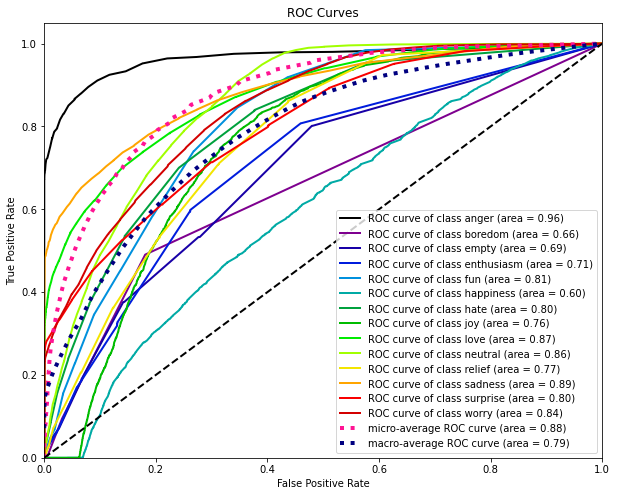

{'f1': 0.44361240690727555, 'roc_auc_score_macro': 0.7871208126258304}

In [86]:
evaluation(rf_clf, test_features, test_labels)